Importing Libraries and Data

[Kaggle](https://www.kaggle.com/code/bhaveshjain1612/machine-failure-prediction)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('darkgrid')

In [2]:
df = pd.read_csv('./datasets/predictive_maintenance.csv')

In [3]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


Data preprocessing

We don't need UDI and Product Id, because they don't carry useful information

In [5]:
df = df.drop(["UDI", "Product ID"], axis=1)
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,M,298.1,308.6,1551,42.8,0,0,No Failure
1,L,298.2,308.7,1408,46.3,3,0,No Failure
2,L,298.1,308.5,1498,49.4,5,0,No Failure
3,L,298.2,308.6,1433,39.5,7,0,No Failure
4,L,298.2,308.7,1408,40.0,9,0,No Failure


Preprocessing for Classification

Encoding

In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
label_encoder = LabelEncoder()

In [8]:
label_encoder.fit(df['Type'])
df['Type'] = label_encoder.transform(df['Type'])

In [9]:
label_encoder.fit(df['Target'])
df['Target'] = label_encoder.transform(df['Target'])

In [10]:
df.tail(3)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
9997,2,299.0,308.6,1645,33.4,22,0,No Failure
9998,0,299.0,308.7,1408,48.5,25,0,No Failure
9999,2,299.0,308.7,1500,40.2,30,0,No Failure


In [12]:
df['nf'] = df['Tool wear [min]'] * df['Torque [Nm]']

Train Test Split

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
  df.drop(['Failure Type', 'Target'], axis=1), 
  df['Target'],
  test_size=0.3,
  random_state=42
)

Prediction

In [16]:
# Import models
import time
from sklearn.metrics import accuracy_score, classification_report
classifier = []
imported_as = []


# KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
classifier.append('k Nearest Neighbors')
imported_as.append('knn')

# SVM
from sklearn.svm import SVC
svc = SVC()
classifier.append('Support Vector Machine')
imported_as.append('svc')

# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
classifier.append('Logistic Regression')
imported_as.append('lr')

classifiers = pd.DataFrame({
  'Classifier': classifier,
  'Imported as': imported_as
})

print('All Models Imported\nModels stored in dataframe called classifiers')

All Models Imported
Models stored in dataframe called classifiers


In [17]:
class Modelling:
    def __init__(self, X_train, Y_train, X_test, Y_test, models):
        self.X_train = X_train
        self.X_test = X_test
        self.Y_train = Y_train
        self.Y_test = Y_test
        self.models = models
    
    def fit(self):
        model_acc = []
        model_time= []
        for i in self.models:
            start=time.time()
            if i == 'knn':
                accuracy = []
                for j in range(1,200):    
                    kn = KNeighborsClassifier(n_neighbors=j)
                    kn.fit(self.X_train,self.Y_train)
                    predK = kn.predict(self.X_test)
                    accuracy.append([accuracy_score(self.Y_test,predK),j])
                temp = accuracy[0]
                for m in accuracy:
                    if temp[0] < m[0]:
                        temp=m
                i = KNeighborsClassifier(n_neighbors=temp[1])
            i.fit(self.X_train,self.Y_train)
            model_acc.append(accuracy_score(self.Y_test,i.predict(self.X_test)))
            stop=time.time()
            model_time.append((stop-start))
            print(i,'has been fit')
        self.models_output = pd.DataFrame({'Models':self.models,'Accuracy':model_acc,'Runtime (s)':model_time})
        
    def results(self):
        models=self.models_output
        models = models.sort_values(by=['Accuracy','Runtime (s)'],ascending=[False,True]).reset_index().drop('index',axis=1)
        self.best = models['Models'][0]
        models['Models']=models['Models'].astype(str).str.split("(", n = 2, expand = True)[0]
        models['Accuracy']=models['Accuracy'].round(5)*100
        self.models_output_cleaned=models
        return(models)
        
    def best_model(self,type):
        if type=='model':
            return(self.best)
        elif type=='name':
            return(self.models_output_cleaned['Models'][0])
    
    def best_model_accuracy(self):
        return(self.models_output_cleaned['Accuracy'][0])
    
    def best_model_runtime(self):
        return(round(self.models_output_cleaned['Runtime (s)'][0],3))
    
    def best_model_predict(self,X_test):
        return(self.best.predict(X_test))
    
    def best_model_clmatrix(self):
        return(classification_report(self.Y_test,self.best.predict(self.X_test)))

In [18]:
display(classifiers)

,Classifier,Imported as
0,k Nearest Neighbors,knn
1,Support Vector Machine,svc
2,Logistic Regression,lr


In [19]:
models_to_test = [knn, svc, lr]

In [20]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 9069 to 7270
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     7000 non-null   int32  
 1   Air temperature [K]      7000 non-null   float64
 2   Process temperature [K]  7000 non-null   float64
 3   Rotational speed [rpm]   7000 non-null   int64  
 4   Torque [Nm]              7000 non-null   float64
 5   Tool wear [min]          7000 non-null   int64  
 6   nf                       7000 non-null   float64
dtypes: float64(4), int32(1), int64(2)
memory usage: 410.2 KB


In [21]:
classification = Modelling(X_train, y_train, X_test, y_test, models_to_test)
classification.fit()

KNeighborsClassifier(n_neighbors=1) has been fit
SVC() has been fit
LogisticRegression() has been fit


In [22]:
classification.results()

,Models,Accuracy,Runtime (s)
0,LogisticRegression,97.333,0.092983
1,SVC,97.233,0.340965
2,KNeighborsClassifier,96.067,0.083038


In [23]:
print('BestModel is:',  classification.best_model(type='name'))
print('Accuracy of model:',classification.best_model_accuracy())
print('Training Runtime in seconds',classification.best_model_runtime())
print('Classification Matrix:\n')
print(classification.best_model_clmatrix())

BestModel is: LogisticRegression
Accuracy of model: 97.333
Training Runtime in seconds 0.093
Classification Matrix:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2907
           1       0.68      0.27      0.38        93

    accuracy                           0.97      3000
   macro avg       0.83      0.63      0.69      3000
weighted avg       0.97      0.97      0.97      3000



C:\Users\Ahmad\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


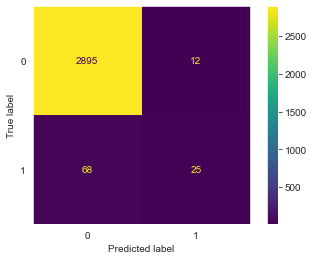

In [24]:
sns.set_style("darkgrid", {
  "grid.color": "1",
  "grid.linestyle": " "
})

from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(
  classification.best_model(type="model"),
  X_test,
  y_test
)